In [1]:
%pip install -q "monai[gdown, nibabel, tqdm]"
%pip install -q matplotlib
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import glob
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss
from monai.metrics import compute_meandice
from monai.networks.layers import Norm
from monai.networks.nets import UNet, BasicUNet
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
    RandGaussianNoised,
    RandFlipd,
    RandAffined,
    SpatialPadd,
)
from monai.utils import first, set_determinism

print_config()

MONAI version: 0.4.0
Numpy version: 1.19.2
Pytorch version: 1.8.0a0+1606899
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0563a4467fa602feca92d91c7f47261868d171a1

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.16.2
Pillow version: 6.2.1
Tensorboard version: 1.15.0+nv
gdown version: 3.12.2
TorchVision version: 0.9.0a0
ITK version: 5.1.2
tqdm version: 4.55.1
lmdb version: 1.0.0
psutil version: 5.7.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
train_images = sorted(glob.glob("../input/mri/*.nii.gz"))
train_labels = sorted(glob.glob("../input/masks/*.nii"))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [4]:
set_determinism(seed=0)

In [5]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="LPS"),
        Spacingd(keys=["image", "label"], pixdim=(1.25, 1.25, 5.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"],  a_min=-1000.0, a_max=500.0, b_min=0.0, b_max=1.0, clip=True
        ),
        SpatialPadd(["image", "label"], spatial_size=(192, 192, -1), mode="reflect"),
        RandAffined(
                    ["image", "label"],
                    prob=0.15,
                    rotate_range=(-0.05, 0.05),
                    scale_range=(-0.1, 0.1),
                    mode=("bilinear", "nearest"),
                    as_tensor_output=False,
                ),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(192, 192, 16),
            num_samples=3,
        ),
        RandGaussianNoised(["image"], prob=0.15, std=0.01),
        RandFlipd(["image", "label"], spatial_axis=0, prob=0.5),
        RandFlipd(["image", "label"], spatial_axis=1, prob=0.5),
        RandFlipd(["image", "label"], spatial_axis=2, prob=0.5),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True,
        ),
        # CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

image shape: torch.Size([207, 207, 116]), label shape: torch.Size([207, 207, 116])


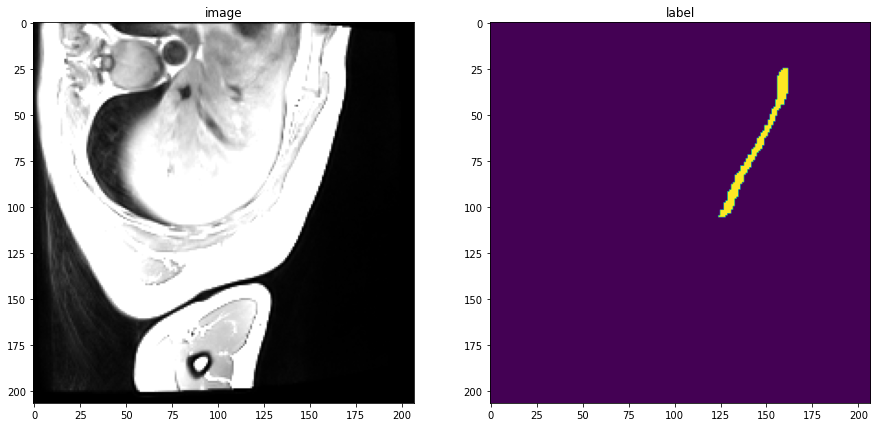

In [6]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (15, 8))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 11], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 11])
plt.show()

In [7]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=16)
# train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

100%|██████████| 9/9 [00:02<00:00,  4.41it/s]


In [8]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = BasicUNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    features=(32, 32, 64, 128, 256, 32),
    dropout=0.1,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

BasicUNet features: (32, 32, 64, 128, 256, 32).


In [9]:
epoch_num = 600
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
post_pred = AsDiscrete(argmax=True, to_onehot=True, n_classes=2)
post_label = AsDiscrete(to_onehot=True, n_classes=2)

for epoch in range(epoch_num):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}", end="\r")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.0
            metric_count = 0
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (192, 192, 16)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = post_pred(val_outputs)
                val_labels = post_label(val_labels)
                value = compute_meandice(
                    y_pred=val_outputs,
                    y=val_labels,
                    include_background=False,
                )
                metric_count += len(value)
                metric_sum += value.sum().item()
            metric = metric_sum / metric_count
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join("../model/unet_testing/", "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}"
            )

----------
epoch 1/600
epoch 1 average loss: 0.5543
----------
epoch 2/600
epoch 2 average loss: 0.4790
saved new best metric model
current epoch: 2 current mean dice: 0.2472
best mean dice: 0.2472 at epoch: 2
----------
epoch 3/600
epoch 3 average loss: 0.4611
----------
epoch 4/600
epoch 4 average loss: 0.4369
saved new best metric model
current epoch: 4 current mean dice: 0.3058
best mean dice: 0.3058 at epoch: 4
----------
epoch 5/600
epoch 5 average loss: 0.4383
----------
epoch 6/600
epoch 6 average loss: 0.4190
saved new best metric model
current epoch: 6 current mean dice: 0.3689
best mean dice: 0.3689 at epoch: 6
----------
epoch 7/600
epoch 7 average loss: 0.4085
----------
epoch 8/600
epoch 8 average loss: 0.4010
saved new best metric model
current epoch: 8 current mean dice: 0.3818
best mean dice: 0.3818 at epoch: 8
----------
epoch 9/600
epoch 9 average loss: 0.3852
----------
epoch 10/600
epoch 10 average loss: 0.3785
current epoch: 10 current mean dice: 0.3008
best mean 

KeyboardInterrupt: 